# Atlas annotation with snapseed
We developed snapseed to quickly provide marker-based annotations on large datasets. This can be very handy to provide "seed annotations" for label-dependent integration methods such as scANVI or scPoli. 

Snapseed is based on the idea that a marker gene of a cell type should be specific for that cell type *and* should be expressed in a large fraction of the cells of that type. As a measure of specificity, snapseed computes single-feature ROC-AUC scores for each marker gene in each cluster. Together with the fraction of cells expressing the gene, we obtain a score that is used to assign clusters to cell types. 

In this notebook, we'll showcase how to use snapseed to annotate cell types in the Human Neural Organoid Atlas dataset.  

In [1]:
import os
import scvi 
import scanpy as sc
import pandas as pd
import numpy as np

from flax.core.frozen_dict import FrozenDict

import hnoca.snapseed as snap
from hnoca.snapseed.utils import read_yaml

os.chdir("/home/fleckj/scratch/hnoca/")

In [3]:
# Read input data
hnoca_adata = sc.read("HNOCA_hv2k.h5ad")
print(hnoca_adata)

AnnData object with n_obs × n_vars = 1770578 × 2000
    obs: 'assay_sc', 'assay_differentiation', 'assay_type_differentiation', 'bio_sample', 'cell_line', 'cell_type', 'development_stage', 'disease', 'ethnicity', 'gm', 'id', 'individual', 'organ', 'organism', 'sex', 'state_exact', 'sample_source', 'source_doi', 'suspension_type_original', 'tech_sample', 'treatment', 'assay_sc_original', 'cell_line_original', 'cell_type_original', 'development_stage_original', 'disease_original', 'ethnicity_original', 'organ_original', 'organism_original', 'sex_original', 'suspension_type', 'obs_names_original', 'organoid_age_days', 'publication', 'doi', 'batch', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'leiden_pca_unintegrated_1', 'leiden_pca_unintegrated_80', 'leiden_pca_rss_1', 'leiden_pca_rss_80', 'snapseed_pca_unintegrated_level_1', 'snapseed_pca_unintegrated_level_2', 'snapseed_pca_unintegrate

In it's most basic form, snapeed takes adata object and a dict with marker genes for different cell types. A very simple example might look like this:

In [4]:
marker_dict = dict(
    neuron = ['STMN2', 'DCX'],
    progenitor = ['SOX2', 'VIM', 'NES'],
)

assignments = snap.annotate(hnoca_adata, marker_dict, group_name="leiden_pca_rss_80")
assignments = assignments.set_index('leiden_pca_rss_80')

The output of snapseed is a pandas dataframe with annotations for each cluster. We can join this information back to the adata object to visualize the annotations on the single-cell level.  

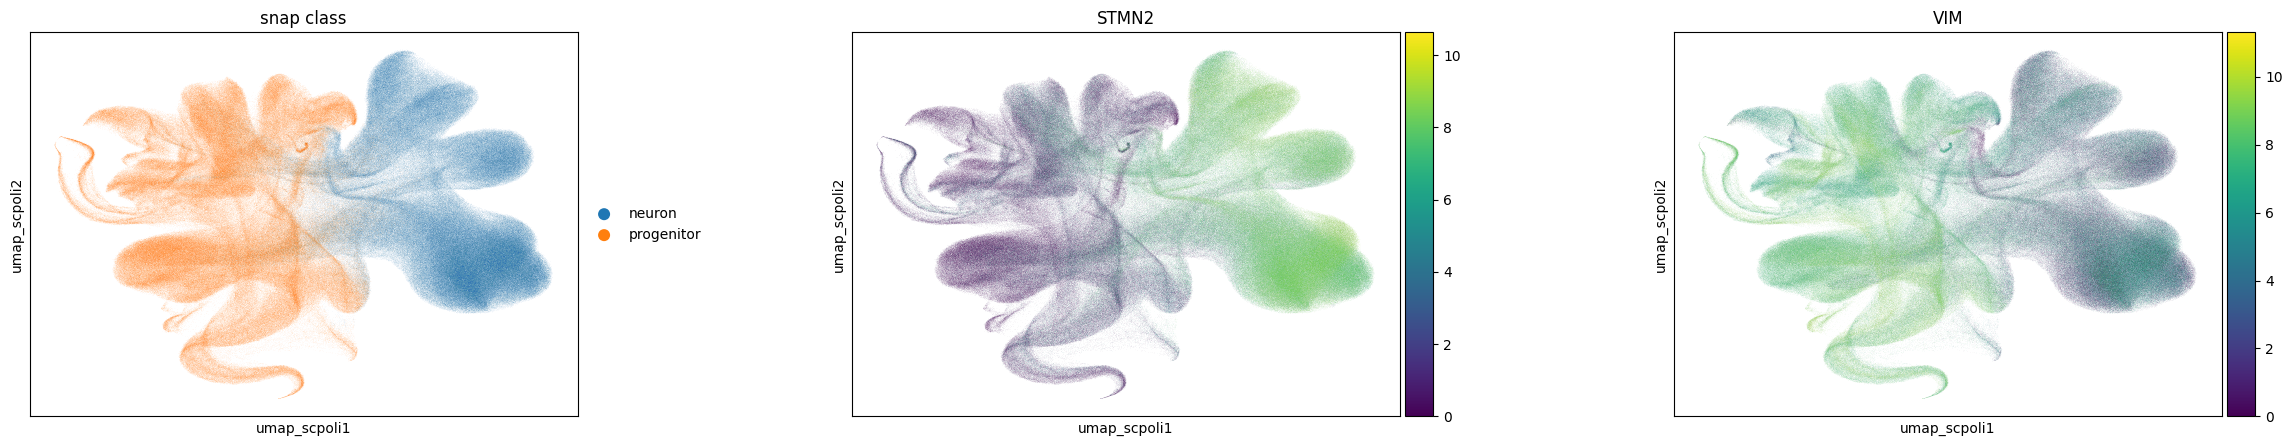

In [5]:
cell_assign  = assignments.loc[hnoca_adata.obs['leiden_pca_rss_80'].astype(str).values, :]
hnoca_adata.obs["snap_class"] = cell_assign["class"].values

# Plot the annotations
sc.pl.scatter(hnoca_adata, color=["snap_class", "STMN2", "VIM"], basis="umap_scpoli")

This looks quite reasonable, so let's make it a bit more interesting. In practice, cell type annotations are often hierachical, so we might want to take this into account in the annotation process. For example, we can first annotate progenitors and neurons and then split them up into more fine-grained subtypes and regional identities. 

Snapseed allows this by recusively annotating cells based on a hierarchy of cell types and marker genes. Such a hierarchy can be provided as a YAML file like [this one](https://github.com/theislab/neural_organoid_atlas/blob/main/supplemental_files/Data_S1_snapseed_markers.yaml):

*(The `FrozenDict` is just to enable better printing of a large dictionary)*

In [5]:
marker_hierarchy = read_yaml("brain_markers.yaml")
print(FrozenDict(marker_hierarchy))

FrozenDict({
    neural_progenitor_cell: {
        marker_genes: ['SOX2', 'VIM', 'NES'],
        subtypes: {
            glioblast: {
                marker_genes: ['HOPX', 'BCAN', 'TNC'],
            },
            telencephalic_npc: {
                marker_genes: ['FOXG1'],
                subtypes: {
                    dorsal_npc: {
                        marker_genes: ['EMX1'],
                    },
                    hippocampal_npc: {
                        marker_genes: ['GABRA2', 'GABRB1'],
                    },
                    ventral_npc: {
                        marker_genes: ['DLX2'],
                    },
                },
            },
            diencephalic_npc: {
                marker_genes: ['TCF7L2', 'SIX3'],
                subtypes: {
                    hypothalamic_npc: {
                        marker_genes: ['SIX3'],
                    },
                    thalamic_npc: {
                        marker_genes: ['TCF7L2'],
                    

In [6]:
assignments = snap.annotate_hierarchy(
    hnoca_adata, 
    marker_hierarchy, 
    group_name="leiden_pca_rss_80"
)

In [7]:
assignments

{'assignments':                                      level_1            level_2  \
 leiden_pca_rss_80                                                 
 0                     neural_progenitor_cell          glioblast   
 1                                     neuron                NaN   
 10                    neural_progenitor_cell          glioblast   
 100                                   neuron  inhibitory_neuron   
 1000                  neural_progenitor_cell  telencephalic_npc   
 ...                                      ...                ...   
 995                                   neuron  inhibitory_neuron   
 996                   neural_progenitor_cell  telencephalic_npc   
 997                                   neuron                NaN   
 998                                   neuron                NaN   
 999                choroid_plexus_epithelium                NaN   
 
                                            level_3  \
 leiden_pca_rss_80                          

Now, snapseeds outputs a dictionary with the assignment dataframe, as well as the hierarchy. Again, we can plot the result as in a UMAP.

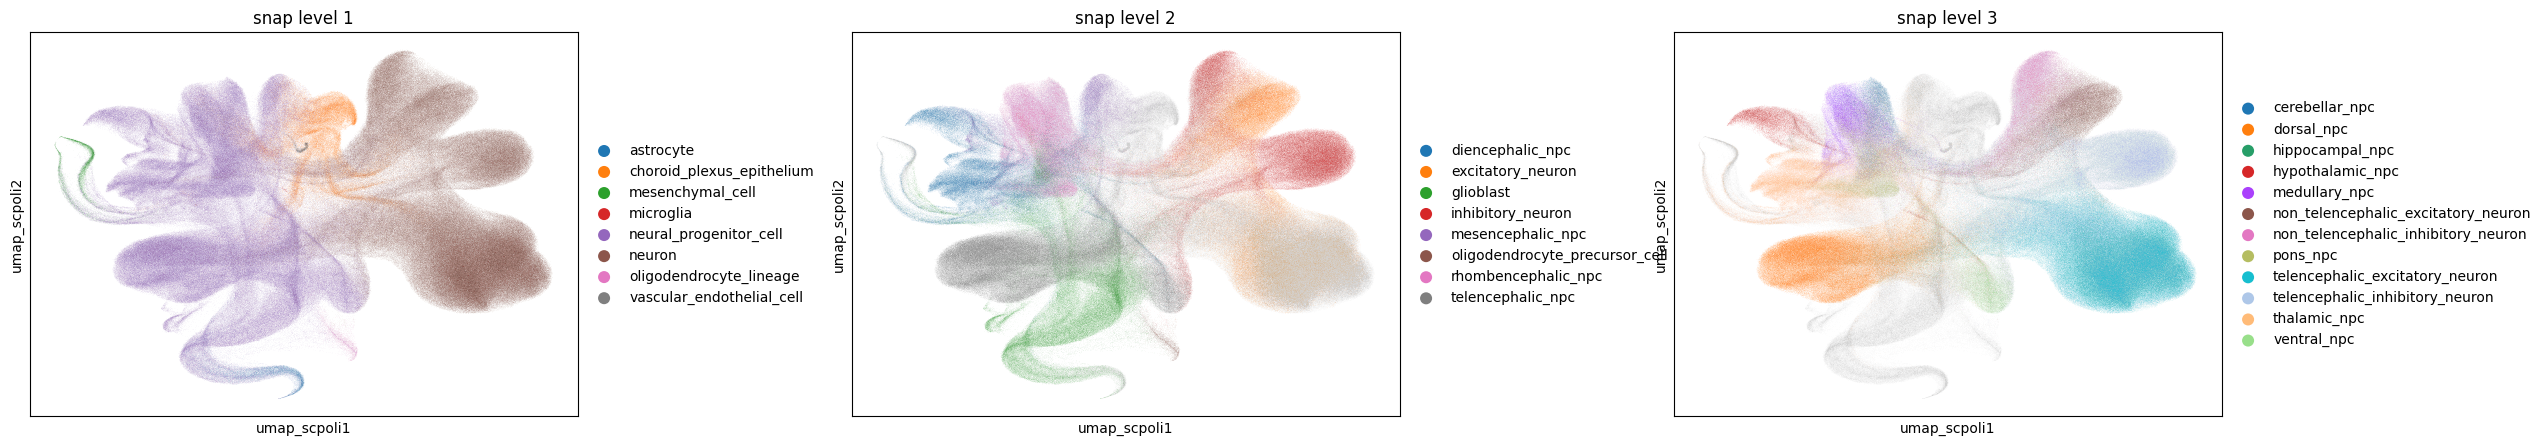

In [12]:
cell_assign  = assignments["assignments"].loc[hnoca_adata.obs['leiden_pca_rss_80'].astype(str).values, :]
hnoca_adata.obs["snap_level_1"] = cell_assign["level_1"].values
hnoca_adata.obs["snap_level_2"] = cell_assign["level_2"].values
hnoca_adata.obs["snap_level_3"] = cell_assign["level_3"].values

# Plot the annotations
sc.pl.scatter(hnoca_adata, color=["snap_level_1", "snap_level_2", "snap_level_3"], basis="umap_scpoli")